In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data=pd.read_csv("..\\datasets\\16-spam-detection-using-tensorflow\\SPAM text message 20170820 - Data.csv")
# data source : https://www.kaggle.com/datasets/team-ai/spam-text-message-classification/data

In [3]:
data.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


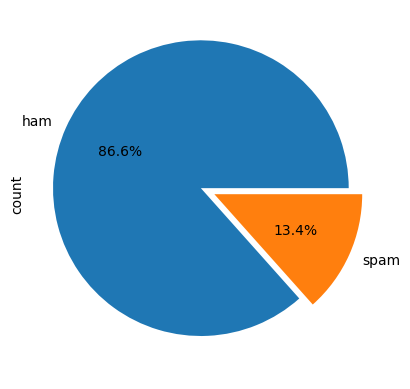

In [4]:
category_df=data['Category'].value_counts().plot(kind='pie',autopct='%1.1f%%',explode=(0.1,0))

In [5]:
import nltk
import re
from nltk.corpus import stopwords
import string

nltk.download('stopwords')
stemmer=nltk.SnowballStemmer('english')
stopword=set(stopwords.words('english'))
def clean(text):
    text = str(text).lower() #lower case all text
    text = re.sub('\[.*?\]', '', text) # remove all characters between []
    text = re.sub('https?://\S+|www\.\S+', '', text) # remove URLs
    text = re.sub('<.*?>+', '', text) # remove all characters between <>
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) # remove punctuation
    text = re.sub('\n', '', text) # remove line breaker
    text = re.sub('\w*\d\w*', '', text) # remove word with numbers
    text = [word for word in text.split(' ') if word not in stopword] # remove word if in stopword
    text=" ".join(text)
    text = [stemmer.stem(word) for word in text.split(' ')] #stemming
    text=" ".join(text)
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shich\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
data['Message']=data['Message'].apply(clean)

In [7]:
spam_word_array=[]
for m in data[data['Category']=='spam']['Message'].to_list():
    for word in m.split():
        spam_word_array.append(word)
df=pd.DataFrame(spam_word_array).value_counts().to_frame().head(20)
df.T.style.background_gradient(cmap='Reds',axis=1)

0,"('call',)","('£',)","('free',)","('txt',)","('u',)","('ur',)","('text',)","('mobil',)","('stop',)","('claim',)","('repli',)","('prize',)","('get',)","('week',)","('tone',)","('servic',)","('send',)","('new',)","('nokia',)","('award',)"
count,363,293,217,150,145,144,138,135,115,113,109,92,87,84,73,72,70,69,68,66


In [8]:
ham_word_array=[]
for m in data[data['Category']=='ham']['Message'].to_list():
    for word in m.split():
        ham_word_array.append(word)
df=pd.DataFrame(ham_word_array).value_counts().to_frame().head(20)
df.T.style.background_gradient(cmap='Blues',axis=1)

0,"('u',)","('im',)","('go',)","('get',)","('come',)","('call',)","('ltgt',)","('ok',)","('dont',)","('ur',)","('know',)","('like',)","('love',)","('ill',)","('got',)","('good',)","('time',)","('day',)","('want',)","('need',)"
count,985,452,417,360,295,289,276,273,265,246,244,244,241,240,232,225,219,215,213,176


In [9]:
MAX_WORDS=pd.DataFrame(spam_word_array+ham_word_array).nunique()[0]

In [10]:
data['Message_length']=data['Message'].apply(len)

In [11]:
MAX_LEN=data['Message_length'].max()

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(data['Message'].values)

In [13]:
word_index=tokenizer.word_index

In [14]:
import math
vocab_size = len(word_index)  # Assuming you have a word index from your dataset
embedding_dim = int(math.sqrt(vocab_size) / 2)  # Adjust the constant factor as needed
embedding_dim

41

In [15]:
from sklearn import preprocessing
labelencoder = preprocessing.LabelEncoder()
data['Category'] = labelencoder.fit_transform(data['Category'])
Y = data['Category'].values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (5572,)


In [16]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
X = tokenizer.texts_to_sequences(data['Message'].values)
X = pad_sequences(X, maxlen=MAX_LEN)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (5572, 477)


In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.3, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(3900, 477) (3900,)
(1672, 477) (1672,)


In [18]:
import tensorflow as tf
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=30000,output_dim = 30, input_length=X_train.shape[1] ))
model.add(tf.keras.layers.LSTM(128, return_sequences=True))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(128, activation="relu"))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 477, 30)           900000    
                                                                 
 lstm (LSTM)                 (None, 477, 128)          81408     
                                                                 
 dropout (Dropout)           (None, 477, 128)          0         
                                                                 
 dense (Dense)               (None, 477, 128)          16512     
                                                                 
 dropout_1 (Dropout)         (None, 477, 128)          0         
                                                                 
 flatten (Flatten)           (None, 61056)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6

In [20]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
# Train the model
epochs = 10
history=model.fit(X_train, Y_train ,validation_data=(X_test, Y_test),epochs=epochs,callbacks=[early_stop],verbose=2)

Epoch 1/10
122/122 - 77s - loss: 0.2807 - accuracy: 0.8990 - val_loss: 0.0840 - val_accuracy: 0.9755 - 77s/epoch - 630ms/step
Epoch 2/10
122/122 - 76s - loss: 0.0516 - accuracy: 0.9859 - val_loss: 0.0727 - val_accuracy: 0.9785 - 76s/epoch - 620ms/step
Epoch 3/10
122/122 - 86s - loss: 0.0199 - accuracy: 0.9944 - val_loss: 0.0499 - val_accuracy: 0.9850 - 86s/epoch - 702ms/step
Epoch 4/10
122/122 - 89s - loss: 0.0119 - accuracy: 0.9982 - val_loss: 0.0544 - val_accuracy: 0.9856 - 89s/epoch - 734ms/step
Epoch 5/10
122/122 - 83s - loss: 0.0096 - accuracy: 0.9982 - val_loss: 0.0709 - val_accuracy: 0.9880 - 83s/epoch - 680ms/step
Epoch 6/10
122/122 - 77s - loss: 0.0059 - accuracy: 0.9985 - val_loss: 0.0670 - val_accuracy: 0.9833 - 77s/epoch - 634ms/step


In [21]:
model.evaluate(X_test, Y_test)

53/53 [==============================] - 7s 137ms/step - loss: 0.0670 - accuracy: 0.9833


[0.06698273122310638, 0.9832535982131958]

In [22]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']
epoch = [i + 1 for i in range(len(train_acc))]

In [23]:
acc_loss_df = pd.DataFrame({"Training Loss" : train_loss,
                            "Validation Loss": val_loss,
                            "Train Accuracy" : train_acc,
                            "Validation Accuracy" : val_acc,
                            "Epoch":epoch})


acc_loss_df.style.bar()

,Training Loss,Validation Loss,Train Accuracy,Validation Accuracy,Epoch
0,0.280666,0.084049,0.898974,0.975478,1
1,0.051577,0.072675,0.985897,0.978469,2
2,0.019895,0.049891,0.994359,0.985048,3
3,0.011851,0.054431,0.998205,0.985646,4
4,0.009600,0.070903,0.998205,0.988038,5
5,0.005879,0.066983,0.998462,0.983254,6


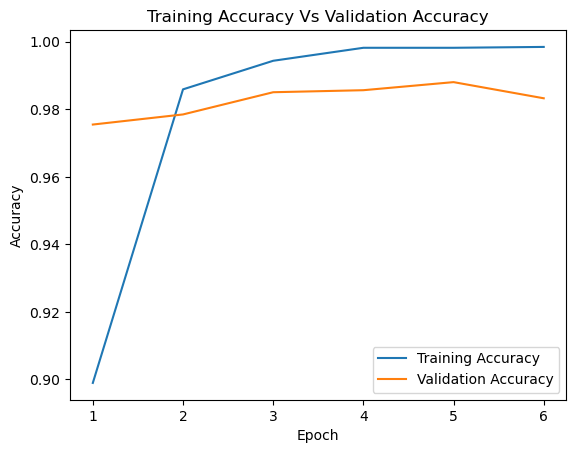

In [38]:
fig = plt.figure()

plt.plot(acc_loss_df['Epoch'],acc_loss_df['Train Accuracy'],label='Training Accuracy')
plt.plot(acc_loss_df['Epoch'],acc_loss_df['Validation Accuracy'],label = 'Validation Accuracy')
plt.title('Training Accuracy Vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


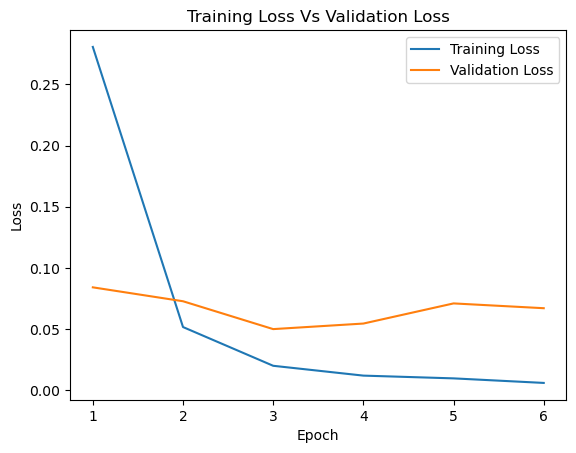

In [40]:
fig = plt.figure()

plt.plot(acc_loss_df['Epoch'],acc_loss_df['Training Loss'],label='Training Loss')

plt.plot(acc_loss_df['Epoch'],acc_loss_df['Validation Loss'],label= 'Validation Loss')

plt.title('Training Loss Vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [41]:
threshold = 0.5
result = model.predict(X_test, verbose=2)
result = result > threshold
result = result.astype("int32")

53/53 - 7s - 7s/epoch - 123ms/step


In [42]:
from sklearn.metrics import classification_report
target_names = ['spam','ham']
print(classification_report(Y_test, result, target_names=target_names))

              precision    recall  f1-score   support

        spam       0.99      0.99      0.99      1448
         ham       0.95      0.92      0.94       224

    accuracy                           0.98      1672
   macro avg       0.97      0.96      0.96      1672
weighted avg       0.98      0.98      0.98      1672



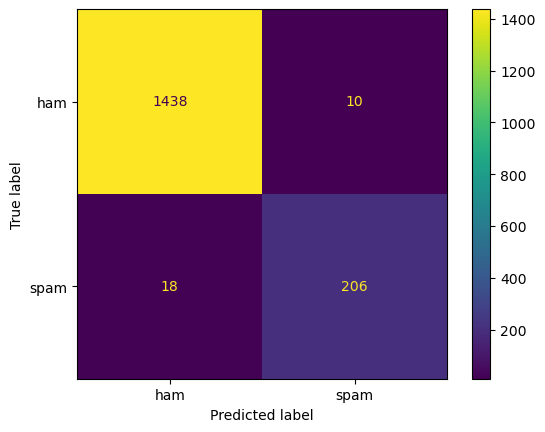

In [47]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
cm = confusion_matrix(Y_test,result)
classes = ['ham','spam']
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes)
disp.plot()
plt.show()

In [29]:
testText="I‘m going to try for 2 months ha ha only joking"
predict_msg = ["	SIX chances to win CASH! From 100 to 20,000 pounds txt> CSH11 and send to 87575. Cost 150p/day, 6days, 16+ TsandCs apply Reply HL 4 info"]
def predict_spam(predict_msg, threshold=0.5):
    new_seq = tokenizer.texts_to_sequences(predict_msg)
    padded = pad_sequences(new_seq, maxlen=MAX_LEN)
    predictions = model.predict(padded)
    for pred in predictions:
        if pred > threshold:
            print("Spam")
        else:
            print("Ham")

# Example usage
predict_msg = ["Your free trail is going to end, renew it"]
predict_spam(predict_msg)

1/1 [==============================] - 0s 55ms/step
Ham
